In [2]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,LassoCV
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile,f_regression,SelectKBest
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error


In [3]:
df=pd.read_csv('EDA.csv')

In [189]:
df.corr();

In [190]:

X=df[df.columns.difference(['rank'],sort = False)]
y=df['rank']
print("X.shape: {} y.shape: {}".format(X.shape,y.shape))

X.shape: (1000, 50) y.shape: (1000,)


In [191]:
#Split the data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)
print("\n\n X_train_val shape: {}\n X_train shape: {}\n X_test shape: {}\n X_val shape:{}\n ".format(X_train_val.shape,X_train.shape,X_test.shape,X_val.shape))



 X_train_val shape: (800, 50)
 X_train shape: (600, 50)
 X_test shape: (200, 50)
 X_val shape:(200, 50)
 


## Baseline Model fit



In [193]:
lr=LinearRegression().fit(X_train,y_train)
y_pred = lr.predict(X_val)


      
print("LR Training R2 score: {:.3f} ".format(lr.score(X_train,y_train)))
print("The validation R2 score: {:.3f}".format(r2_score(y_val,y_pred)))
print("The Validation RMSE:  {:.3f}".format(mean_squared_error(y_val,y_pred,squared=False)))
print("The Validation MAE:  {:.2f}".format(mean_absolute_error(y_val, y_pred)))



LR Training R2 score: 0.428 
The validation R2 score: 0.283
The Validation RMSE:  968.920
The Validation MAE:  815.64


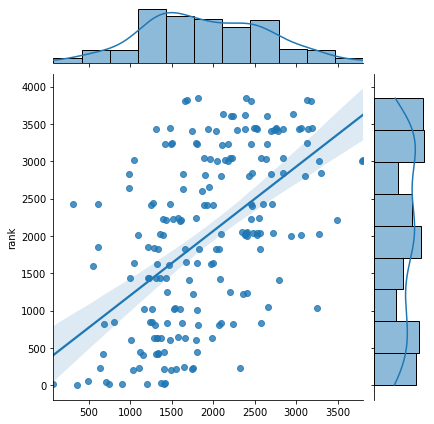

In [194]:
sns.jointplot(x=y_pred,y=y_val, kind='reg')

In [195]:
import scipy.stats as stats
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

Diagnostic plots for training:




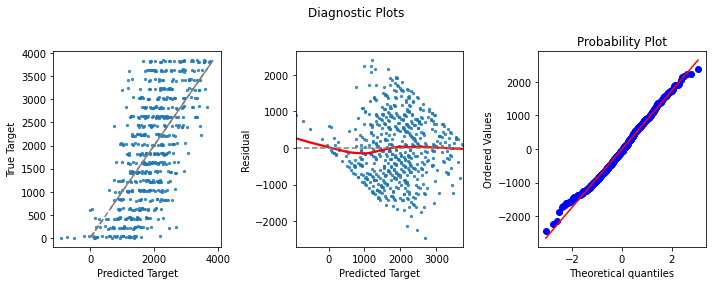

In [196]:

model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()
fit.summary()
print("Diagnostic plots for training:\n\n")
diagnostic_plots(fit.fittedvalues,y_train, fit.resid)

Diagnostic plots for Validation:




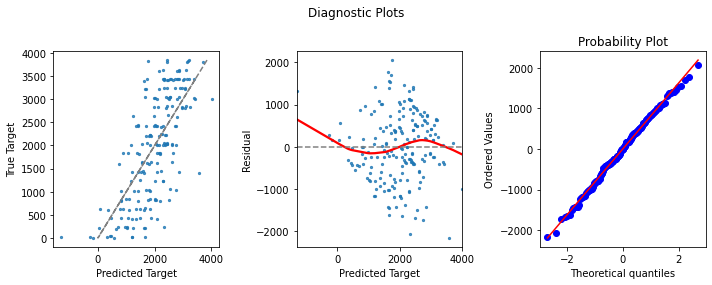

In [197]:

model = sm.OLS(y_val, sm.add_constant(X_val)) 
fit = model.fit()
fit.summary()
print("Diagnostic plots for Validation:\n\n")
diagnostic_plots(fit.fittedvalues,y_val, fit.resid)

In [70]:
kf = KFold(n_splits=5, shuffle=True, random_state = 10000)

print(np.mean(cross_val_score(lr, X_train_val, y_train_val, cv=kf, scoring='r2')))

0.3159041733984201


## *  If the accuracy from the cross-validation method is less than the accuracy from the holdout method, it indicates model overfitting.

### Lets try lasso and ridge,but scale data first

In [198]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lr=LinearRegression().fit(X_train_scaled,y_train)
ridge=Ridge(alpha=1.0).fit(X_train_scaled,y_train)
lasso=Lasso().fit(X_train_scaled,y_train)

lr_pred = lr.predict(X_val_scaled)
ridge_pred=ridge.predict(X_val_scaled)
lasso_pred=lasso.predict(X_val_scaled)


print("LR Training score: {:.3f} ".format(lr.score(X_train_scaled,y_train)))
print("LR Val score: {:.3f}".format(lr.score(X_val_scaled,y_val)))
print("LR_Val RMSE:  {:.3f}".format(np.sqrt(mean_squared_error(y_val,lr_pred))))

print("\n""Ridge Training score: {:.3f} ".format(ridge.score(X_train_scaled,y_train)))
print("Ridge Val score: {:.3f} ".format(ridge.score(X_val_scaled,y_val)))
print("Ridege_Val RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_val,ridge_pred))))

print("\n""Lasso Training score: {:.3f} ".format(lasso.score(X_train_scaled,y_train)))
print("Lasso Val score: {:.3f} ".format(lasso.score(X_val_scaled,y_val)))
print("Number of features used:", np.sum(lasso.coef_ != 0))
print("Lasso_val RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_val,lasso_pred))))

LR Training score: 0.428 
LR Val score: 0.283
LR_Val RMSE:  968.920

Ridge Training score: 0.428 
Ridge Val score: 0.284 
Ridege_Val RMSE: 968.092

Lasso Training score: 0.427 
Lasso Val score: 0.287 
Number of features used: 48
Lasso_val RMSE: 965.557


## Scaling made a tiny difference on the validation and the RMSE.# Try binning now

In [210]:
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
X_train_binned = kb.fit_transform(X_train_scaled)
X_val_binned = kb.fit_transform(X_val_scaled)

X_binned = kb.transform(X_train_scaled)
X_val_binned = kb.transform(X_val_scaled)

lr=LinearRegression().fit(X_binned,y_train)
ridge=Ridge().fit(X_binned,y_train)
lasso=Lasso().fit(X_binned,y_train)

lr_pred = lr.predict(X_val_binned)
ridge_pred=ridge.predict(X_val_binned)
lasso_pred=lasso.predict(X_val_binned)

print("X_binned shape: {}, X_train shape: {}\n\n".format(X_binned.shape,X_train_scaled.shape))

print("LR Training score: {} ".format(lr.score(X_binned,y_train)))
print("LR Val score: {} ".format(lr.score(X_val_binned,y_val)))
print("LR_Val RMSE:  {:.3f}".format(np.sqrt(mean_squared_error(y_val,lr_pred))))



print("\n""Ridge Training score: {} ".format(ridge.score(X_binned,y_train)))
print("Ridge val score: {} ".format(ridge.score(X_val_binned,y_val)))
print("Ridege_Val RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_val,ridge_pred))))

print("\n""Lasso Training score: {} ".format(lasso.score(X_binned,y_train)))
print("Lasso val score: {} ".format(lasso.score(X_val_binned,y_val)))
print("Lasso_val RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_val,lasso_pred))))



X_binned shape: (600, 491), X_train shape: (600, 50)


LR Training score: 0.46740467236684624 
LR Val score: 0.3159313630745183 
LR_Val RMSE:  946.089

Ridge Training score: 0.46392209812374696 
Ridge val score: 0.3270901148795048 
Ridege_Val RMSE: 938.341

Lasso Training score: 0.4602102845318652 
Lasso val score: 0.33425318319512154 
Lasso_val RMSE: 933.333


/Users/yonga/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:199: UserWarning: Feature 39 is constant and will be replaced with 0.
  warnings.warn(


## polynomial features and simultaneously use lasso to regularize becus it would probably overfit

In [ ]:
for i in [1,2,3,4]:
    for j in [1.0,5,10,20,50,70,80]:
        create_poly = PolynomialFeatures(degree=i, interaction_only=False, include_bias=False)
        poly = make_pipeline(create_poly, StandardScaler(), Lasso(alpha=j))
        model = poly.fit(X_train,y_train)
        print ("R2 degree - %2i polynomial :%0.3f" %(i,r2_score(y_train,model.predict(X_train))))
        print("Lasso alpha: {}".format(j))
        print ("Valication R2 degree - %2i polynomial :%0.3f \n\n" %(i,r2_score(y_val,model.predict(X_val))))

In [199]:
#given the above parameters a degree of 2 and alpha 50 was the best option 

In [200]:

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
pipe = make_pipeline(poly, StandardScaler(), Lasso(alpha=50))
model = pipe.fit(X_train,y_train)
print ("Training R2 :", (r2_score(y_train,model.predict(X_train))))
print ("Valication R2 " ,(r2_score(y_val,model.predict(X_val))))

Training R2 : 0.5456376456629088
Valication R2  0.44767270746146426




 pipe RMSE: 850.120


The pipe MAE:  815.64


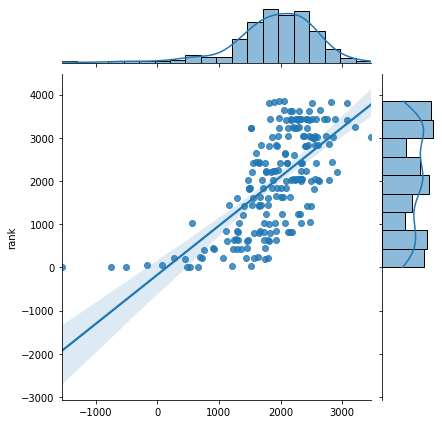

In [202]:
pred=model.predict(X_val)
print("\n\n pipe RMSE: {:.3f}\n\n".format(np.sqrt(mean_squared_error(y_val,pred))))
print("The pipe MAE:  {:.2f}".format(mean_absolute_error(y_val, y_pred)))
sns.jointplot(x=pred,y=y_val, kind='reg')

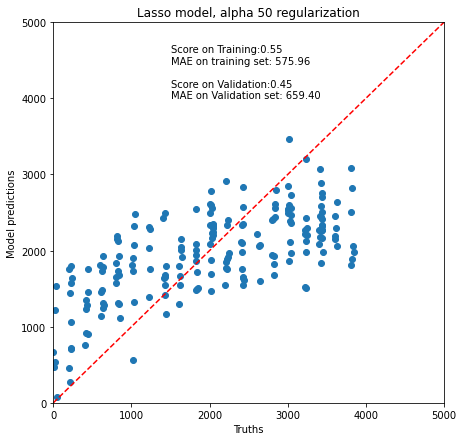

In [203]:
from sklearn.metrics import median_absolute_error
y_pred = model.predict(X_train)

mae = median_absolute_error(y_train, y_pred)
score=model.score(X_train,y_train)
string_score = f"Score on Training:{score:.2f}\nMAE on training set: {mae:.2f}\n\n"
y_pred = model.predict(X_val)
mae = median_absolute_error(y_val, y_pred)
score=model.score(X_val,y_val)
string_score += f"Score on Validation:{score:.2f}\nMAE on Validation set: {mae:.2f}"

fig, ax = plt.subplots(figsize=(7, 7))
plt.scatter(y_val, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(1500, 4000, string_score)
plt.title("Lasso model, alpha 50 regularization")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 5000])
_ = plt.ylim([0, 5000])


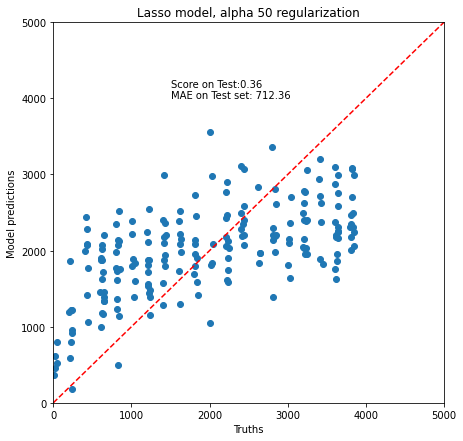

In [204]:


y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
score=model.score(X_test,y_test)
string_score = f"Score on Test:{score:.2f}\nMAE on Test set: {mae:.2f}"
fig, ax = plt.subplots(figsize=(7, 7))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(1500, 4000, string_score)
plt.title("Lasso model, alpha 50 regularization")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 5000])
_ = plt.ylim([0, 5000])

## Training and validation seemed relatively promising but performed poorly on test set

In [145]:
c=[]
f=[]
for coef, var in sorted(zip(map(abs,lasso.coef_), \
           df.columns[:-1]), reverse=True):
           c.append(coef)
           f.append(var)
        
        

In [98]:
d = {'coef':c,'feature':f}

df_cof = pd.DataFrame(d, columns=['coef','feature'])

In [100]:
df_cof.to_csv('coef.csv',header=True, index=False)

In [ ]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train_scaled, y_train, method='lasso')

In [ ]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

## lets try further reducing features by using randomforest

In [205]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

In [206]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (600, 50)
X_train_l1.shape: (600, 25)


In [207]:
X_val_l1 = select.transform(X_val)
print("X_val.shape: {}".format(X_val.shape))
print("X_val_l1.shape: {}".format(X_val_l1.shape))

X_val.shape: (200, 50)
X_val_l1.shape: (200, 25)


In [208]:
score = model.fit(X_train_l1, y_train).score(X_val_l1, y_val)
print("Test score: {:.3f}".format(score))

Test score: 0.375


/Users/yonga/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yonga/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [209]:
X_test_l1 = select.transform(X_test)
score = model.fit(X_test_l1, y_test).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.590


/Users/yonga/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yonga/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


/Users/yonga/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yonga/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


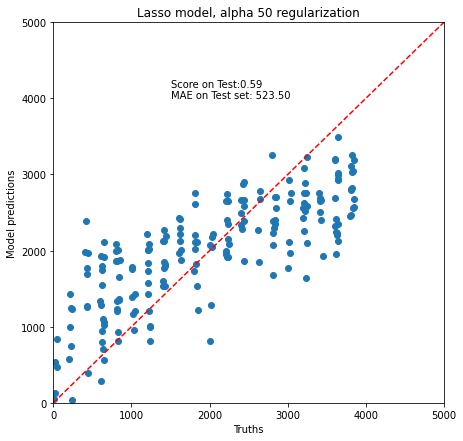

In [221]:
y_pred = model.predict(X_test_l1 )
mae = median_absolute_error(y_test, y_pred)
score=model.score(X_test_l1 ,y_test)
string_score = f"Score on Test:{score:.2f}\nMAE on Test set: {mae:.2f}"
fig, ax = plt.subplots(figsize=(7, 7))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(1500, 4000, string_score)
plt.title("Lasso model, alpha 50 regularization")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 5000])
_ = plt.ylim([0, 5000])

In [222]:
y_test

521    2842
737    3601
740    3640
660    3036
411    2220
       ... 
408    1227
332    3424
208    2845
613    2809
78     1216
Name: rank, Length: 200, dtype: int64

In [137]:
select.get_support()

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
       False, False, False,  True, False,  True,  True, False, False,
        True,  True,  True, False, False, False, False,  True, False,
       False, False, False, False,  True,  True, False, False,  True,
        True, False,  True, False, False])

In [180]:
selected_list=list(select. get_feature_names_out())


In [182]:
final_features = df_cof[df_cof['feature'].isin(selected_list)]

In [183]:
final_features=df_filtered.reset_index(drop=True)

In [184]:
final_features

,coef,feature
0,553.588421,popularity
1,325.129256,type_Special
2,207.618698,members
3,188.430385,type_TV
4,173.653430,type_OVA
5,156.472050,source_Manga
6,121.115637,rating_R - 17+ (violence & profanity)
7,106.826930,genre_Drama
8,81.936714,demographic_other
9,78.831633,rating_G - All Ages


In [185]:
final_features.to_csv('final_features.csv',header=True, index=False)

([], [])

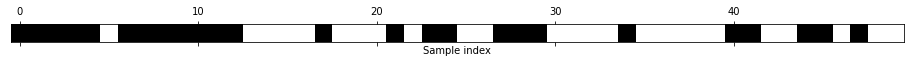

In [80]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [254]:
p=(y_pred).tolist()
p=[int(i) for i in p]
T=(y_test).tolist()
for i in range(len(X_test_l1)):
    if p[i] in range(T[i] -50,T[i]+50):
        print( p[i],T[i])
    


1824 1825
47 13
811 832
2046 2029
2679 2641
3232 3242
1209 1227


In [ ]:
sns.kdeplot(X_train_scaled['members'])

sns.kdeplot(X_train_scaled['genre_Action'])
sns.kdeplot(X_train_scaled['genre_Adventure'])
